## Import TensorFlow and other libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds  # Add this import

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses

from tensorflow.keras.models import Model

2025-10-19 18:52:32.454436: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-19 18:52:32.527706: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-19 18:52:34.083226: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load the dataset
To start, you will train the basic autoencoder using the Fashion MNIST dataset. Each image in this dataset is 28x28 pixels.

In [ ]:
# Load MNIST dataset using tfds
ds = tfds.load('mnist', split=['train', 'test'], as_supervised=True)
(ds_train, ds_test) = ds

# Convert to numpy arrays
def preprocess_mnist(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    return image

# Apply preprocessing and convert to numpy
x_train = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_train])
x_test = np.array([preprocess_mnist(x, y).numpy() for x, y in ds_test])

print(x_train.shape)  # Should be (60000, 28, 28, 1)
print(x_test.shape)   # Should be (10000, 28, 28, 1)

2025-10-19 15:35:05.222683: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
2025-10-19 15:35:05.393739: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:396] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2025-10-19 15:35:32.538834: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(60000, 28, 28, 1)
(10000, 28, 28, 1)


2025-10-19 15:35:37.109106: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


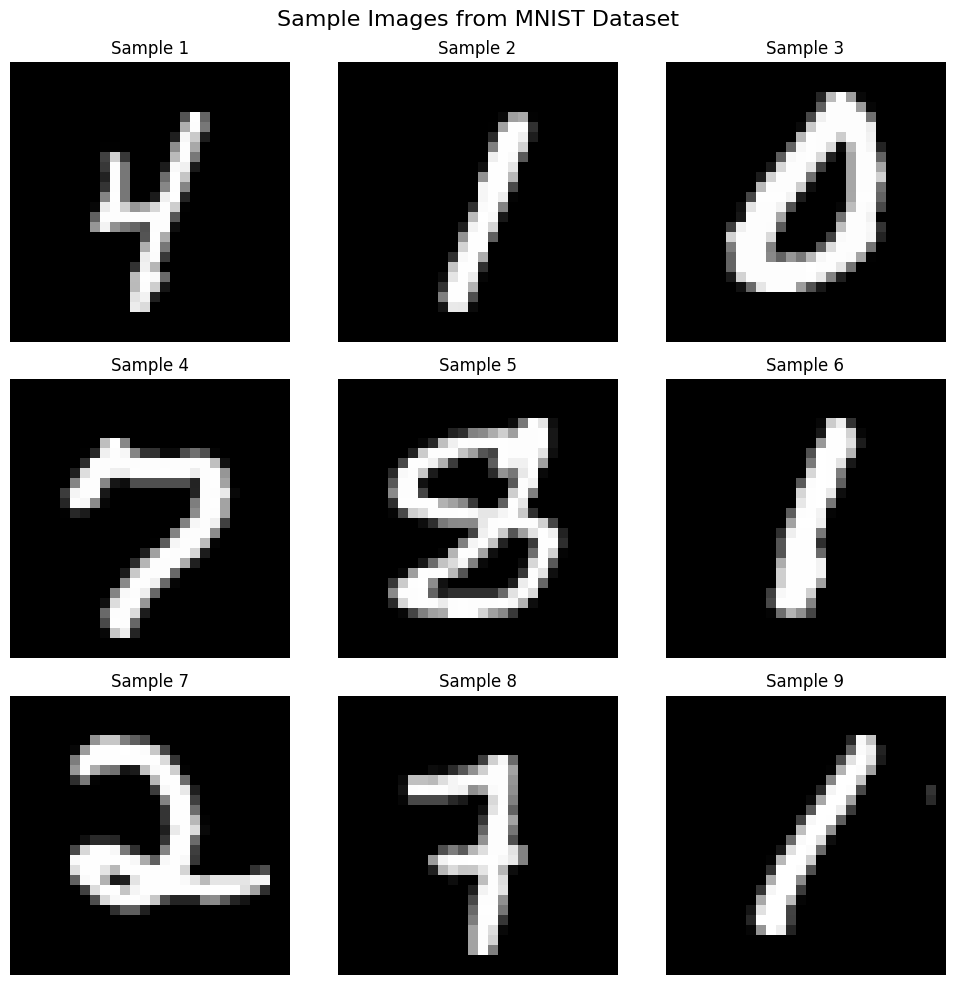

In [ ]:
# Display a 3x3 grid of sample MNIST digits
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_train[i].squeeze(), cmap='gray')  # Use .squeeze() and cmap='gray'
    plt.title(f"Sample {i+1}")
    plt.axis('off')
plt.suptitle("Sample Images from MNIST Dataset", fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# Print comprehensive dataset statistics
print("=== MNIST Dataset Statistics ===")
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")
print(f"Image dimensions: {x_train.shape[1]} x {x_train.shape[2]} pixels")
print(f"Number of channels: {x_train.shape[3]} (Grayscale)")
print(f"Total training samples: {x_train.shape[0]:,}")
print(f"Total test samples: {x_test.shape[0]:,}")
print(f"Data type: {x_train.dtype}")
print(f"Pixel value range: [{x_train.min():.3f}, {x_train.max():.3f}]")
print(f"Memory usage (training): {x_train.nbytes / (1024**2):.1f} MB")
print(f"Memory usage (test): {x_test.nbytes / (1024**2):.1f} MB")

# MNIST class names (digits 0-9)
class_names = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")

=== MNIST Dataset Statistics ===
Training set shape: (60000, 28, 28, 1)
Test set shape: (10000, 28, 28, 1)
Image dimensions: 28 x 28 pixels
Number of channels: 1 (Grayscale)
Total training samples: 60,000
Total test samples: 10,000
Data type: float32
Pixel value range: [0.000, 1.000]
Memory usage (training): 179.4 MB
Memory usage (test): 29.9 MB
Number of classes: 10
Class names: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


## First example: Basic autoencoder
![Basic autoencoder results](https://www.tensorflow.org/static/tutorials/generative/images/intro_autoencoder_result.png)

Define an autoencoder with two Dense layers: an `encoder`, which compresses the images into a 64 dimensional latent vector, and a `decoder`, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/custom_layers_and_models).


In [ ]:
# Define an Autoencoder class inheriting from tf.keras.Model
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()  # Initialize the base class
    self.latent_dim = latent_dim         # Store the size of the latent space
    self.shape = shape                   # Store the original input shape

    # Encoder: flattens input and encodes to latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # Flatten input to 1D
      layers.Dense(latent_dim, activation='relu'),  # Dense layer for encoding
    ])

    # Decoder: reconstructs original shape from latent vector
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),  # Dense layer to expand back to original size
      layers.Reshape(shape)               # Reshape output to original input shape
    ])

  # Forward pass: encode then decode
  def call(self, x):
    encoded = self.encoder(x)             # Encode input
    decoded = self.decoder(encoded)       # Decode latent vector
    return decoded                        # Return reconstruction

# Set the shape and latent dimension for the autoencoder
shape = x_test.shape[1:]                  # Get shape of input images (e.g., (28, 28))
latent_dim = 64                           # Set size of latent space

# Instantiate the Autoencoder model
autoencoder = Autoencoder(latent_dim, shape)


Mean Squared Error (MSE) is commonly used as the loss function for autoencoders working with images because it measures the average squared difference between the original and reconstructed pixel values. This is appropriate for images because:

- **Pixel-wise similarity:** MSE penalizes large differences between corresponding pixels, encouraging the autoencoder to produce reconstructions that are visually similar to the input.
- **Continuous values:** Image data is often represented as continuous values (e.g., pixel intensities between 0 and 1), making MSE a natural choice.
- **Smooth gradients:** MSE provides smooth and stable gradients, which helps neural networks learn effectively during training.

In summary, MSE is simple, effective, and aligns well with the goal of minimizing reconstruction error in image autoencoders.

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

Train the model using `x_train` as both the input and the target. The `encoder` will learn to compress the dataset from 784 dimensions to the latent space, and the `decoder` will learn to reconstruct the original images.
.

In [ ]:
# Store the training history first
history = autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0238 - val_loss: 0.0091
Epoch 2/10
1096/1875 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0083

1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068 - val_loss: 0.0053
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0050 - val_loss: 0.0045
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0045 - val_loss: 0.0043
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0043 - val_loss: 0.0042
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0041 - val_loss: 0.0040
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0040 - val_loss: 0.0039


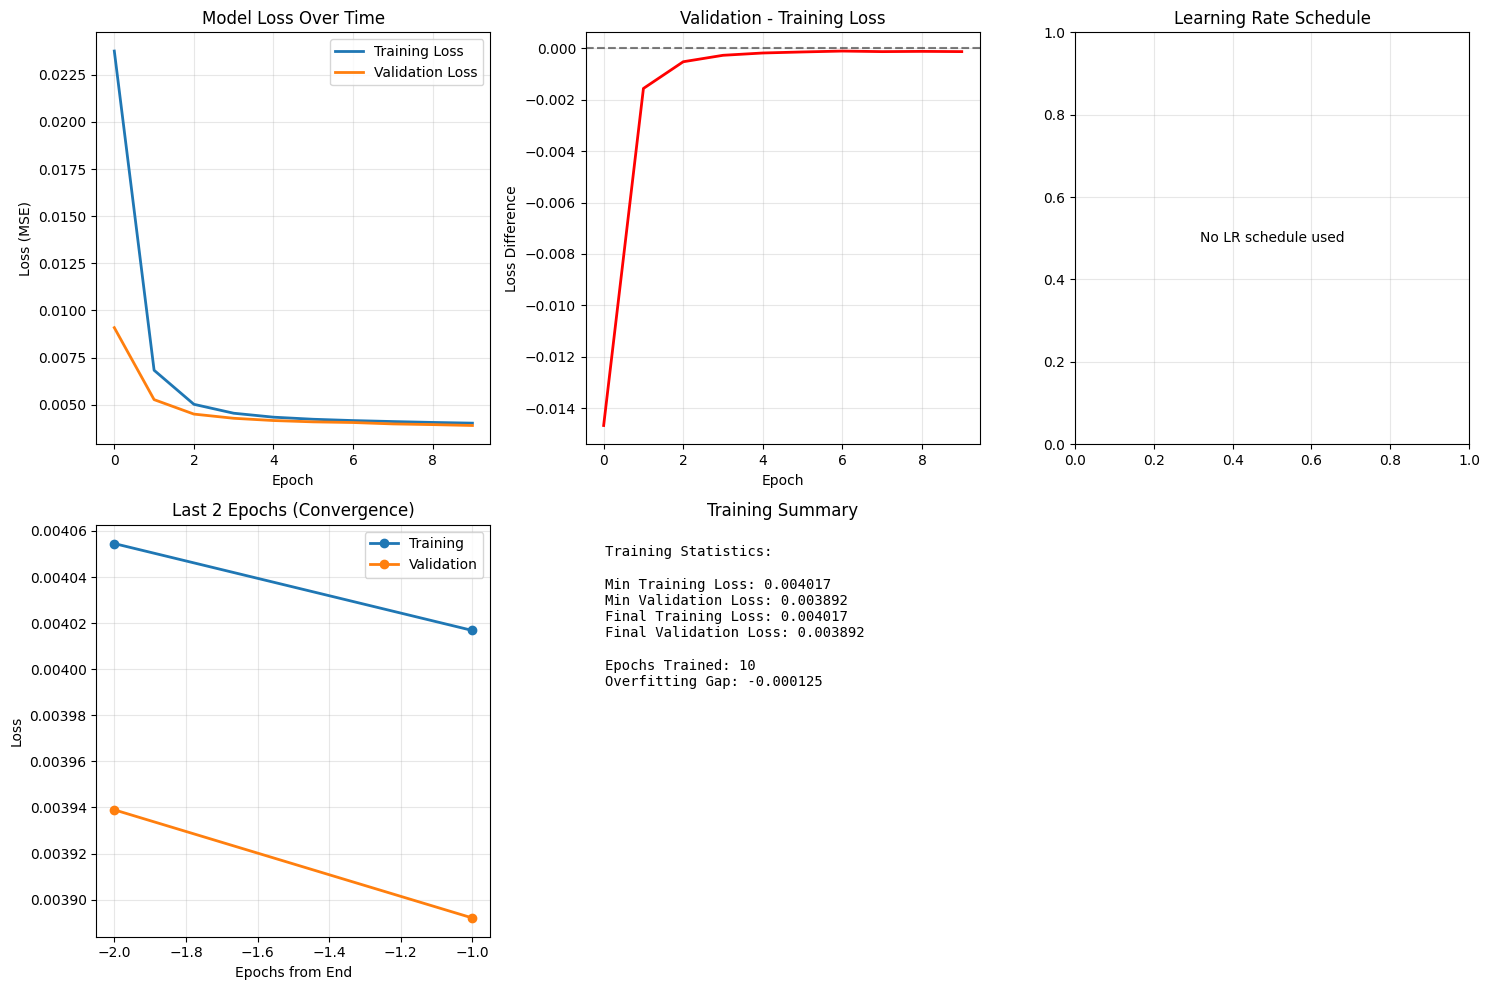

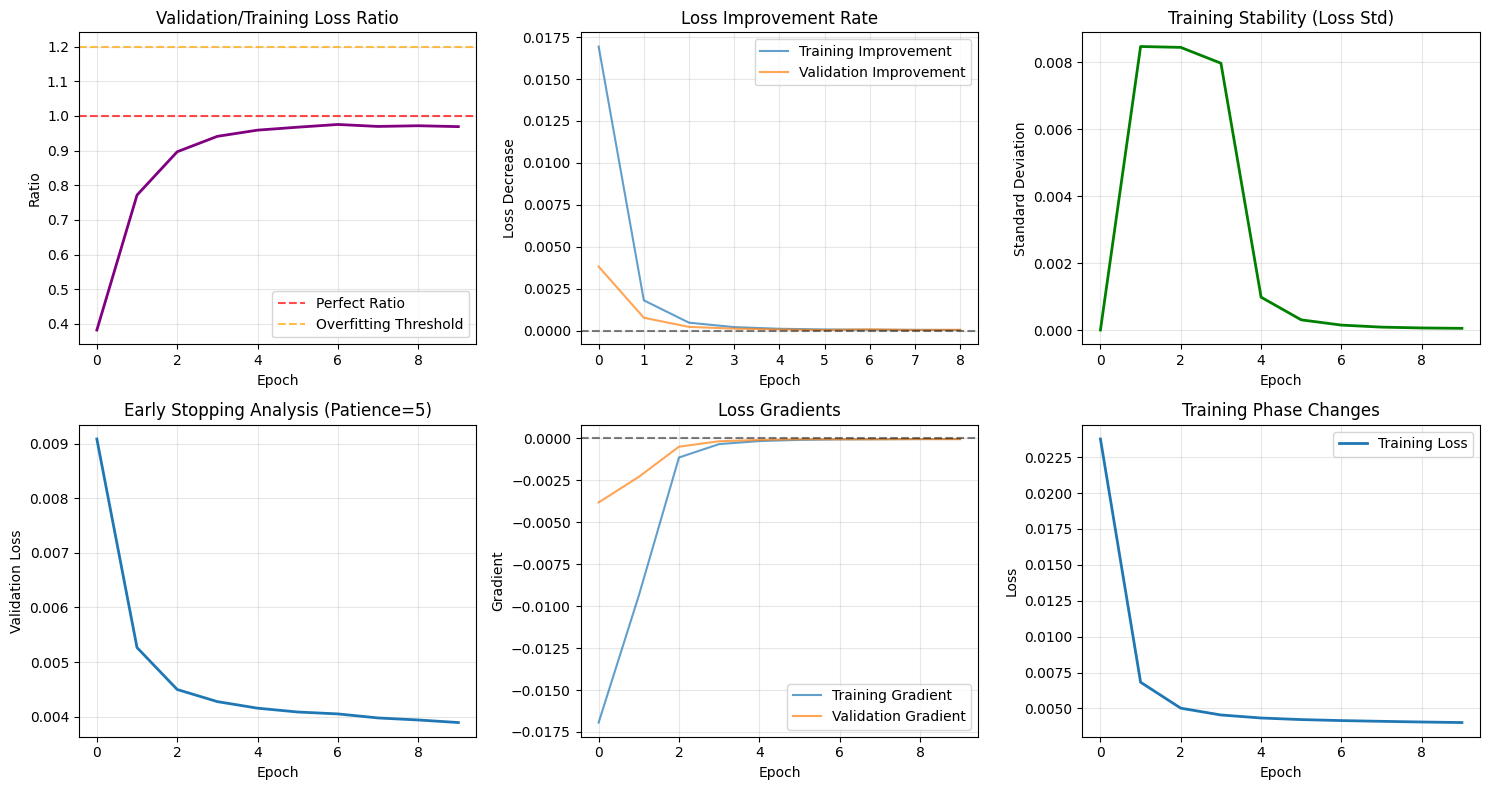

Train errors shape: (1000,)
Test errors shape: (1000,)


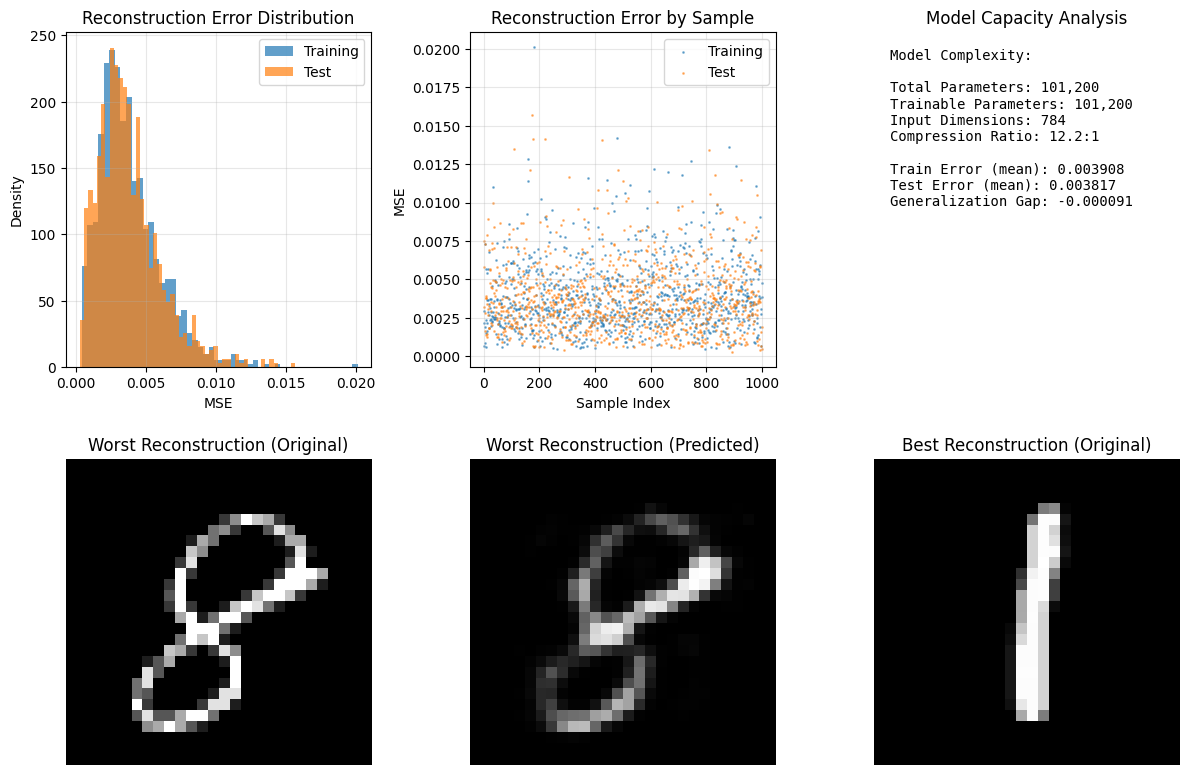

In [ ]:
# 1. Training History Visualization
def plot_training_history(history):
    """Plot comprehensive training metrics"""
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Loss curves
    plt.subplot(2, 3, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    plt.title('Model Loss Over Time')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Loss difference (overfitting indicator)
    plt.subplot(2, 3, 2)
    loss_diff = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(loss_diff, color='red', linewidth=2)
    plt.title('Validation - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Learning rate (if using a scheduler)
    plt.subplot(2, 3, 3)
    if 'lr' in history.history:
        plt.plot(history.history['lr'])
        plt.title('Learning Rate Schedule')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.yscale('log')
    else:
        plt.text(0.5, 0.5, 'No LR schedule used', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Learning Rate Schedule')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Convergence analysis
    plt.subplot(2, 3, 4)
    final_epochs = max(1, len(history.history['loss']) // 4)
    recent_train_loss = history.history['loss'][-final_epochs:]
    recent_val_loss = history.history['val_loss'][-final_epochs:]
    
    plt.plot(range(-final_epochs, 0), recent_train_loss, 'o-', label='Training', linewidth=2)
    plt.plot(range(-final_epochs, 0), recent_val_loss, 'o-', label='Validation', linewidth=2)
    plt.title(f'Last {final_epochs} Epochs (Convergence)')
    plt.xlabel('Epochs from End')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Training statistics
    plt.subplot(2, 3, 5)
    min_train_loss = min(history.history['loss'])
    min_val_loss = min(history.history['val_loss'])
    final_train_loss = history.history['loss'][-1]
    final_val_loss = history.history['val_loss'][-1]
    
    stats_text = f"""Training Statistics:
    
Min Training Loss: {min_train_loss:.6f}
Min Validation Loss: {min_val_loss:.6f}
Final Training Loss: {final_train_loss:.6f}
Final Validation Loss: {final_val_loss:.6f}

Epochs Trained: {len(history.history['loss'])}
Overfitting Gap: {final_val_loss - final_train_loss:.6f}
    """
    
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, 
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    plt.axis('off')
    plt.title('Training Summary')
    
    plt.tight_layout()
    plt.show()

# 2. Real-time reconstruction quality during training
def visualize_reconstruction_progress(model, x_sample, epoch_interval=2):
    """Visualize how reconstructions improve during training"""
    sample_images = x_sample[:5]  # Take 5 sample images
    
    def plot_reconstructions(epoch):
        reconstructions = model(sample_images)
        
        plt.figure(figsize=(15, 6))
        for i in range(5):
            # Original
            plt.subplot(2, 5, i + 1)
            plt.imshow(sample_images[i].squeeze(), cmap='gray')
            plt.title(f'Original {i+1}')
            plt.axis('off')
            
            # Reconstruction
            plt.subplot(2, 5, i + 6)
            plt.imshow(reconstructions[i].squeeze(), cmap='gray')
            plt.title(f'Epoch {epoch}')
            plt.axis('off')
        
        plt.suptitle(f'Reconstruction Quality at Epoch {epoch}')
        plt.tight_layout()
        plt.show()
    
    return plot_reconstructions

# 3. Loss landscape visualization
def plot_loss_landscape_analysis(history):
    """Analyze the loss landscape and training dynamics"""
    plt.figure(figsize=(15, 8))
    
    # Plot 1: Loss ratio analysis
    plt.subplot(2, 3, 1)
    val_train_ratio = np.array(history.history['val_loss']) / np.array(history.history['loss'])
    plt.plot(val_train_ratio, linewidth=2, color='purple')
    plt.axhline(y=1.0, color='red', linestyle='--', alpha=0.7, label='Perfect Ratio')
    plt.axhline(y=1.2, color='orange', linestyle='--', alpha=0.7, label='Overfitting Threshold')
    plt.title('Validation/Training Loss Ratio')
    plt.xlabel('Epoch')
    plt.ylabel('Ratio')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Loss improvement rate
    plt.subplot(2, 3, 2)
    train_improvement = -np.diff(history.history['loss'])
    val_improvement = -np.diff(history.history['val_loss'])
    
    plt.plot(train_improvement, label='Training Improvement', alpha=0.7)
    plt.plot(val_improvement, label='Validation Improvement', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Improvement Rate')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Decrease')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Training stability
    plt.subplot(2, 3, 3)
    window = 3
    train_std = np.array([np.std(history.history['loss'][max(0, i-window):i+1]) 
                         for i in range(len(history.history['loss']))])
    plt.plot(train_std, linewidth=2, color='green')
    plt.title('Training Stability (Loss Std)')
    plt.xlabel('Epoch')
    plt.ylabel('Standard Deviation')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Early stopping analysis
    plt.subplot(2, 3, 4)
    patience = 5
    best_val_loss = np.inf
    patience_counter = 0
    early_stop_points = []
    
    for i, val_loss in enumerate(history.history['val_loss']):
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            early_stop_points.append(i)
    
    plt.plot(history.history['val_loss'], linewidth=2)
    for point in early_stop_points:
        plt.axvline(x=point, color='red', linestyle='--', alpha=0.7)
    plt.title(f'Early Stopping Analysis (Patience={patience})')
    plt.xlabel('Epoch')
    plt.ylabel('Validation Loss')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Gradient estimation
    plt.subplot(2, 3, 5)
    train_gradient = np.gradient(history.history['loss'])
    val_gradient = np.gradient(history.history['val_loss'])
    
    plt.plot(train_gradient, label='Training Gradient', alpha=0.7)
    plt.plot(val_gradient, label='Validation Gradient', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Loss Gradients')
    plt.xlabel('Epoch')
    plt.ylabel('Gradient')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 6: Training phases
    plt.subplot(2, 3, 6)
    epochs = len(history.history['loss'])
    
    # Identify training phases based on loss behavior
    phase_changes = []
    for i in range(1, epochs-1):
        prev_slope = history.history['loss'][i] - history.history['loss'][i-1]
        next_slope = history.history['loss'][i+1] - history.history['loss'][i]
        if prev_slope * next_slope < 0:  # Sign change
            phase_changes.append(i)
    
    plt.plot(history.history['loss'], linewidth=2, label='Training Loss')
    for change in phase_changes:
        plt.axvline(x=change, color='red', linestyle=':', alpha=0.7)
    
    plt.title('Training Phase Changes')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# 4. Model capacity analysis
def analyze_model_capacity(model, x_train, x_test):
    """Analyze if the model has appropriate capacity"""
    plt.figure(figsize=(12, 8))
    
    # Get predictions for analysis
    train_reconstructions = model(x_train[:1000])  # Subset for speed
    test_reconstructions = model(x_test[:1000])
    
    # Compute MSE per sample, not per pixel
    train_errors = tf.reduce_mean(tf.keras.losses.mse(x_train[:1000], train_reconstructions), axis=[1,2])
    test_errors = tf.reduce_mean(tf.keras.losses.mse(x_test[:1000], test_reconstructions), axis=[1,2])
    
    # Plot 1: Error distribution comparison
    plt.subplot(2, 3, 1)
    # print dimensions of train_errors and test_errors for debugging
    print(f"Train errors shape: {train_errors.shape}")
    print(f"Test errors shape: {test_errors.shape}")
    plt.hist(train_errors, bins=50, alpha=0.7, label='Training', density=True)
    plt.hist(test_errors, bins=50, alpha=0.7, label='Test', density=True)
    plt.title('Reconstruction Error Distribution')
    plt.xlabel('MSE')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Error vs sample index
    plt.subplot(2, 3, 2)
    plt.scatter(range(len(train_errors)), train_errors, alpha=0.5, s=1, label='Training')
    plt.scatter(range(len(test_errors)), test_errors, alpha=0.5, s=1, label='Test')
    plt.title('Reconstruction Error by Sample')
    plt.xlabel('Sample Index')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Model complexity metrics
    plt.subplot(2, 3, 3)
    total_params = model.count_params()
    trainable_params = sum([tf.size(var).numpy() for var in model.trainable_variables])
    
    complexity_text = f"""Model Complexity:
    
Total Parameters: {total_params:,}
Trainable Parameters: {trainable_params:,}
Input Dimensions: {np.prod(x_train.shape[1:])}
Compression Ratio: {np.prod(x_train.shape[1:]) / 64:.1f}:1

Train Error (mean): {np.mean(train_errors):.6f}
Test Error (mean): {np.mean(test_errors):.6f}
Generalization Gap: {np.mean(test_errors) - np.mean(train_errors):.6f}
    """
    
    plt.text(0.05, 0.95, complexity_text, transform=plt.gca().transAxes,
             verticalalignment='top', fontfamily='monospace', fontsize=10)
    plt.axis('off')
    plt.title('Model Capacity Analysis')
    
    # Plot 4: Worst reconstruction (Original)
    plt.subplot(2, 3, 4)
    worst_indices = np.argsort(test_errors)[-1]  # Get single worst index
    plt.imshow(x_test[worst_indices].squeeze(), cmap='gray')
    plt.title('Worst Reconstruction (Original)')
    plt.axis('off')
    
    # Plot 5: Worst reconstruction (Predicted)
    plt.subplot(2, 3, 5)
    plt.imshow(test_reconstructions[worst_indices].numpy().squeeze(), cmap='gray')
    plt.title('Worst Reconstruction (Predicted)')
    plt.axis('off')
    
    # Plot 6: Best reconstruction (Original)
    plt.subplot(2, 3, 6)
    best_indices = np.argsort(test_errors)[0]  # Get single best index
    plt.imshow(x_test[best_indices].squeeze(), cmap='gray')
    plt.title('Best Reconstruction (Original)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# ...existing code...
# Then create the visualizations
plot_training_history(history)
plot_loss_landscape_analysis(history)
analyze_model_capacity(autoencoder, x_train, x_test)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

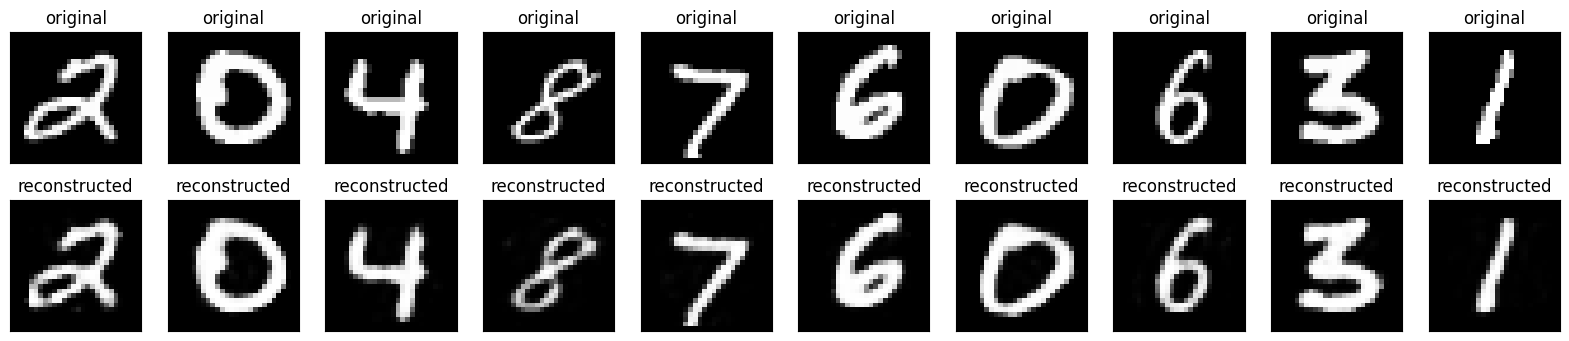

In [ ]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

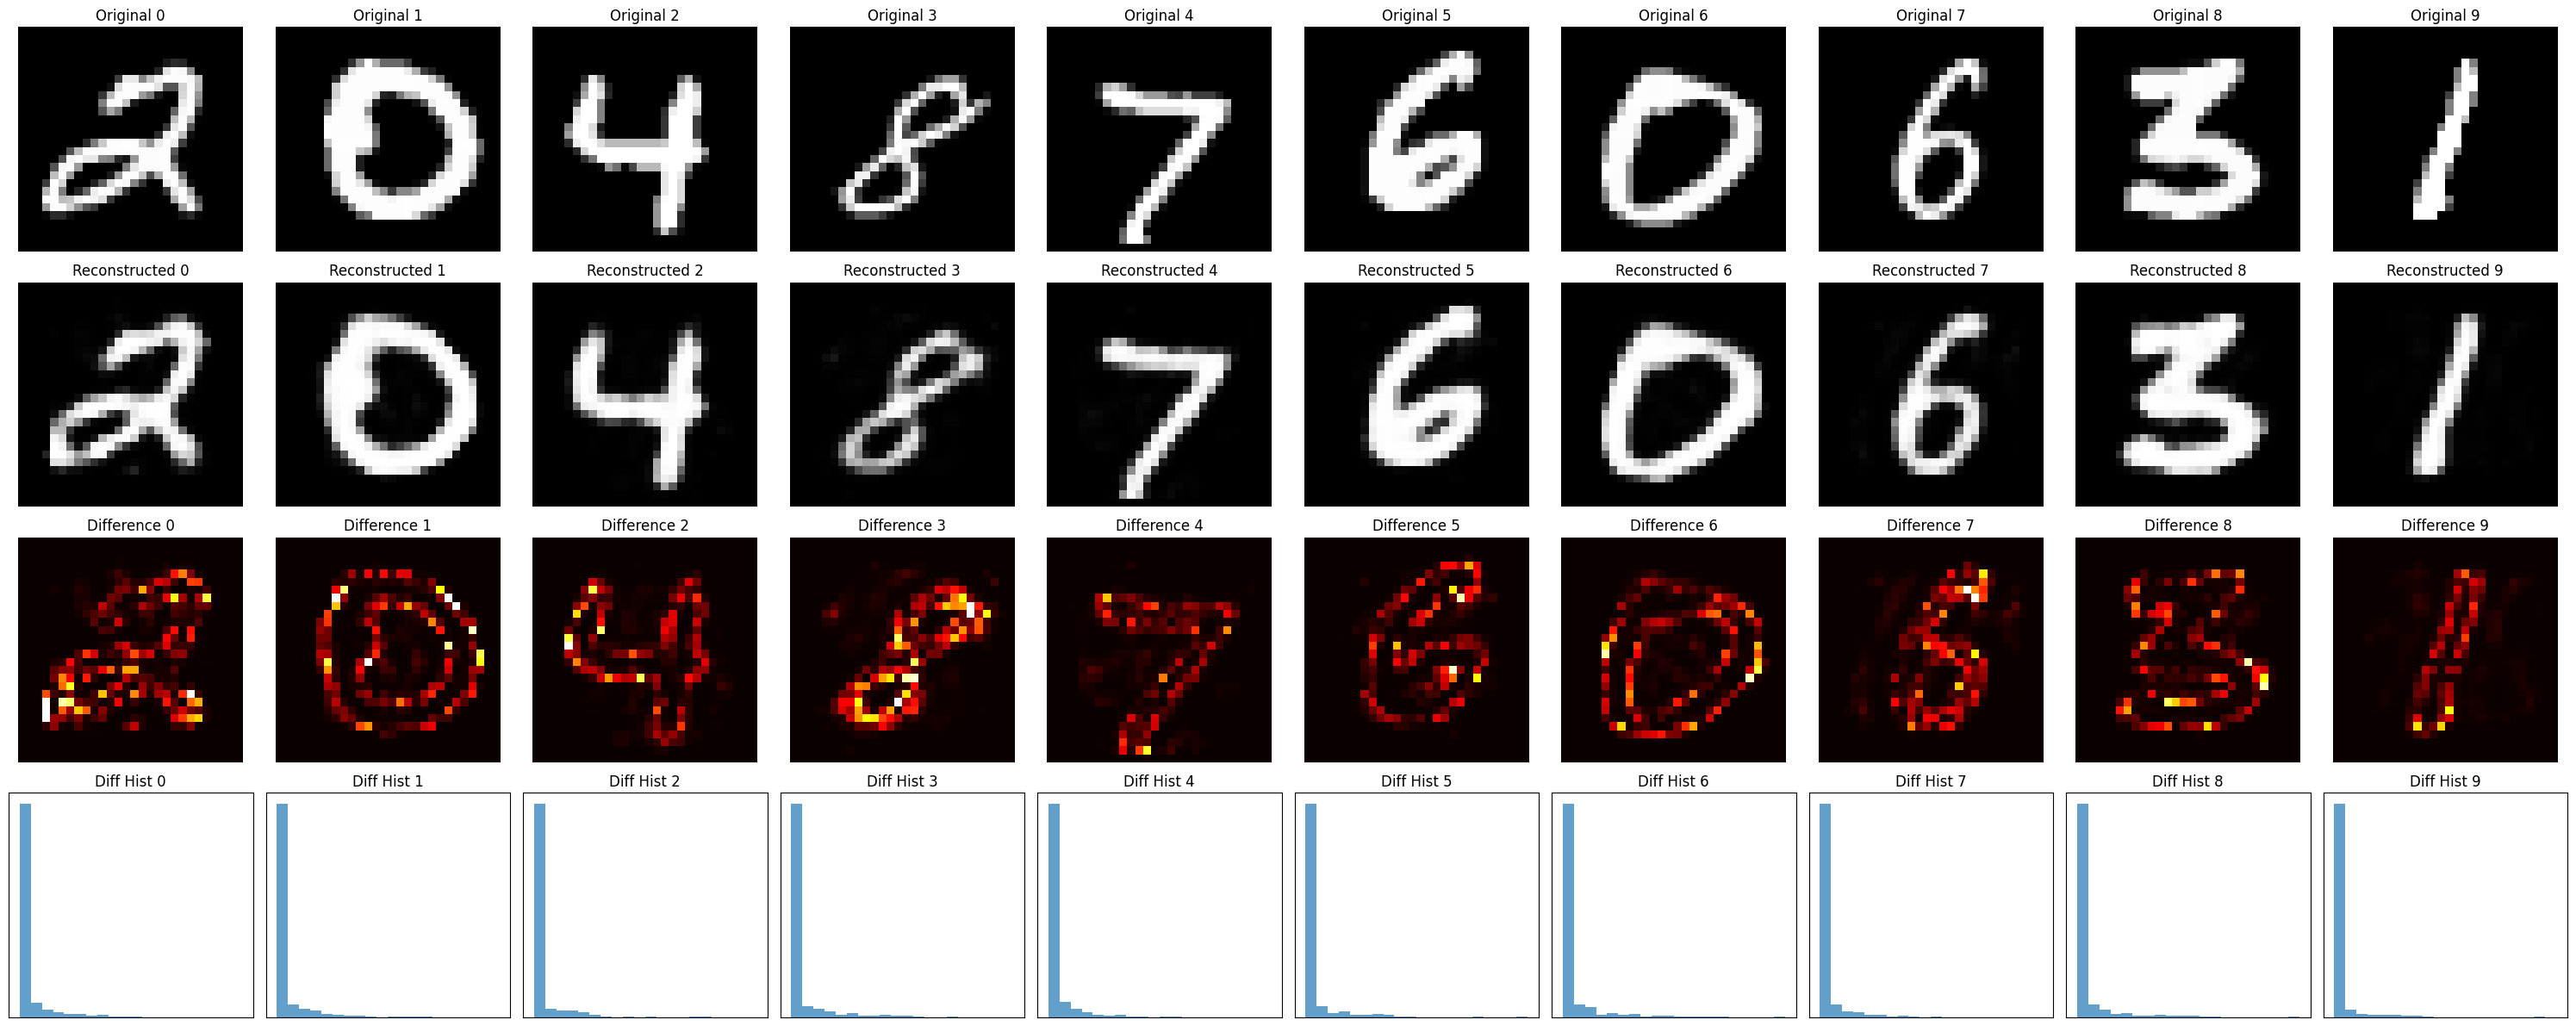

In [ ]:
# Calculate pixel-wise differences
differences = np.abs(x_test[:10] - decoded_imgs[:10])

plt.figure(figsize=(30, 12))
for i in range(10):
    # Original
    plt.subplot(4, 10, i + 1)
    plt.imshow(x_test[i].squeeze(), cmap='gray')
    plt.title(f"Original {i}")
    plt.axis('off')
    
    # Reconstructed
    plt.subplot(4, 10, i + 11)
    plt.imshow(decoded_imgs[i].squeeze(), cmap='gray')
    plt.title(f"Reconstructed {i}")
    plt.axis('off')
    
    # Difference heatmap
    plt.subplot(4, 10, i + 21)
    plt.imshow(differences[i].squeeze(), cmap='hot', vmin=0, vmax=0.5)
    plt.title(f"Difference {i}")
    plt.axis('off')
    
    # Difference histogram
    plt.subplot(4, 10, i + 31)
    plt.hist(differences[i].flatten(), bins=20, alpha=0.7)
    plt.title(f"Diff Hist {i}")
    plt.xticks([]) 
    plt.yticks([])

plt.tight_layout()
plt.show()

## Interpreting the Difference Analysis

### Understanding the Difference Heatmaps
The **difference heatmaps** (third row) show the absolute pixel-wise differences between original and reconstructed images using a "hot" colormap:
- **Dark/Black areas**: Pixels with little to no difference (good reconstruction)
- **Bright/Yellow-Red areas**: Pixels with large differences (poor reconstruction)

**Key Observation**: The brightest regions typically appear at the **edges and boundaries** of each digit. This indicates that the autoencoder struggles most with fine details and sharp transitions between foreground (digit) and background pixels. The model tends to blur or smooth these edge regions during reconstruction.

### Understanding the Difference Histograms
The **difference histograms** (bottom row) show the distribution of pixel-wise differences for each image:

**X-axis**: Difference values (ranging from 0 to ~0.5)
- 0 = Perfect reconstruction (no difference)
- Higher values = Larger reconstruction errors

**Y-axis**: Count of pixels with that difference value

**Key Observations**:
1. **Largest bin at 0**: Most pixels have zero or near-zero difference, indicating the autoencoder successfully reconstructs the majority of pixels
2. **Right-skewed distribution**: Few pixels have large errors, confirming that major reconstruction issues are localized to specific regions (mainly edges)
3. **Long tail**: Some pixels have moderate to high errors, representing the edge artifacts and fine detail losses

This analysis confirms that while the autoencoder performs well overall, it systematically struggles with preserving sharp edges and fine details - a common limitation of

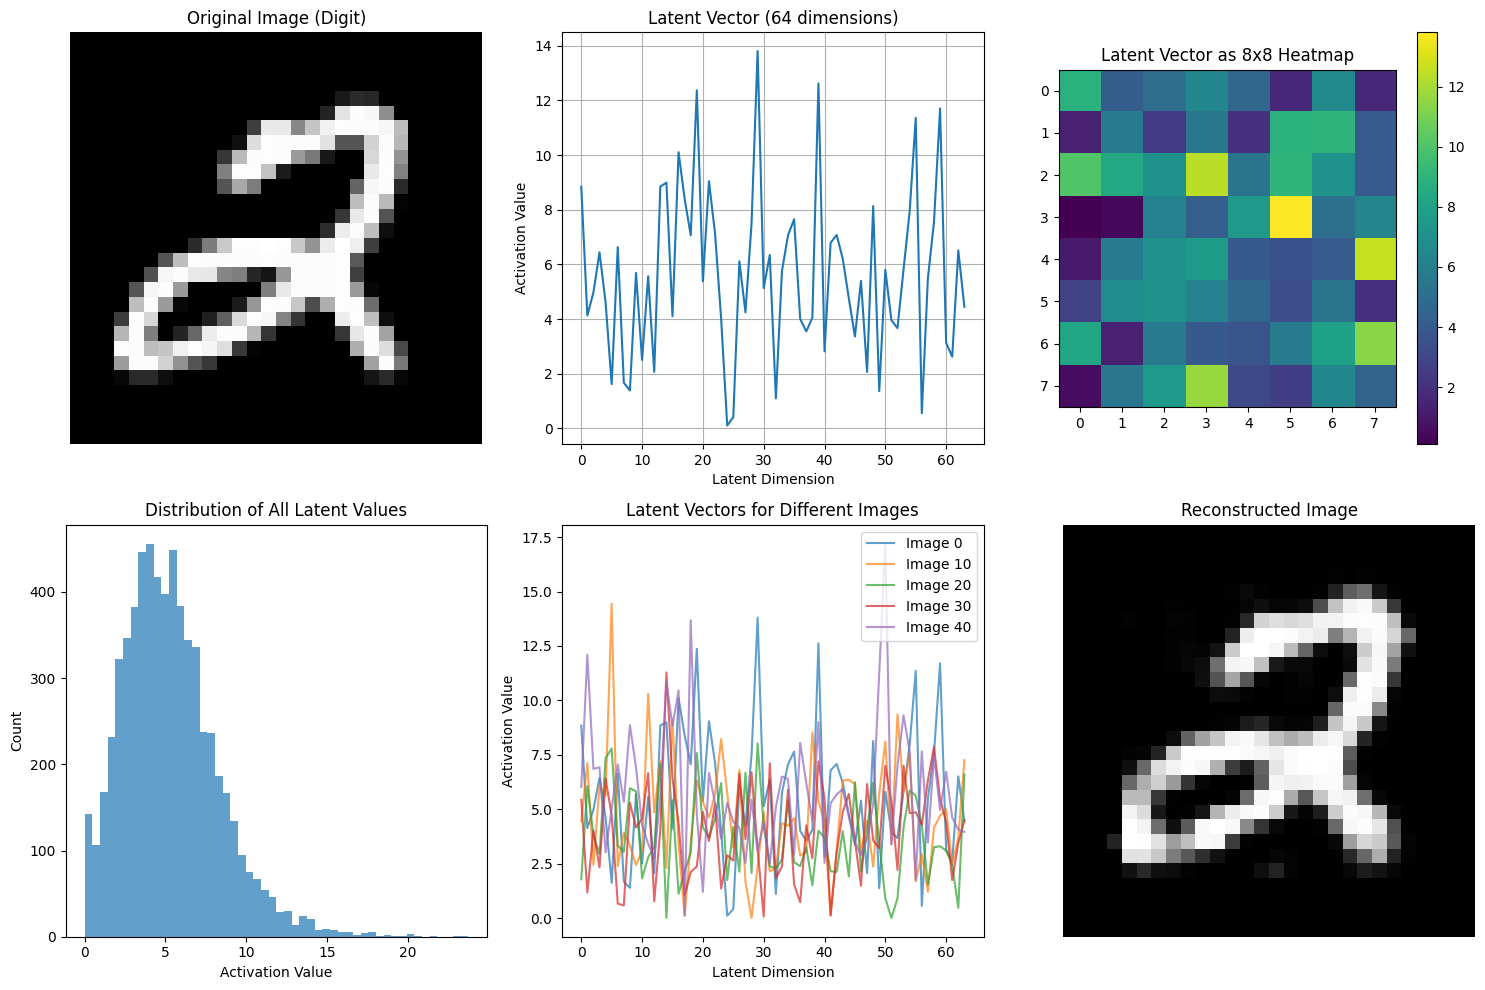

In [ ]:
# Visualize what the encoder learns - the latent representations
def visualize_latent_space():
    # Get encoded representations for a batch of images
    sample_images = x_test[:100] # TODO: this may not be representing total population; shuffle before sampling;
    
    encoded_representations = autoencoder.encoder(sample_images).numpy()
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Show original images
    plt.subplot(2, 3, 1)
    plt.imshow(sample_images[0].squeeze(), cmap='gray')
    plt.title('Original Image (Digit)')
    plt.axis('off')
    
    # Plot 2: Show the 64-dimensional latent vector
    plt.subplot(2, 3, 2)
    plt.plot(encoded_representations[0])
    plt.title('Latent Vector (64 dimensions)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Activation Value')
    plt.grid(True)
    
    # Plot 3: Heatmap of latent representation
    plt.subplot(2, 3, 3)
    plt.imshow(encoded_representations[0].reshape(8, 8), cmap='viridis')
    plt.title('Latent Vector as 8x8 Heatmap')
    plt.colorbar()
    
    # Plot 4: Distribution of all latent values
    plt.subplot(2, 3, 4)
    plt.hist(encoded_representations.flatten(), bins=50, alpha=0.7)
    plt.title('Distribution of All Latent Values')
    plt.xlabel('Activation Value')
    plt.ylabel('Count')
    
    # Plot 5: Compare latent vectors for different digits
    digit_indices = [0, 10, 20, 30, 40]  # Assuming different digits
    plt.subplot(2, 3, 5)
    for i, idx in enumerate(digit_indices):
        plt.plot(encoded_representations[idx], label=f'Image {idx}', alpha=0.7)
    plt.title('Latent Vectors for Different Images')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Activation Value')
    plt.legend()
    
    # Plot 6: Reconstruction
    reconstructed = autoencoder.decoder(encoded_representations[:1]).numpy()
    plt.subplot(2, 3, 6)
    plt.imshow(reconstructed[0].squeeze(), cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

visualize_latent_space()

2025-10-19 15:36:20.966260: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


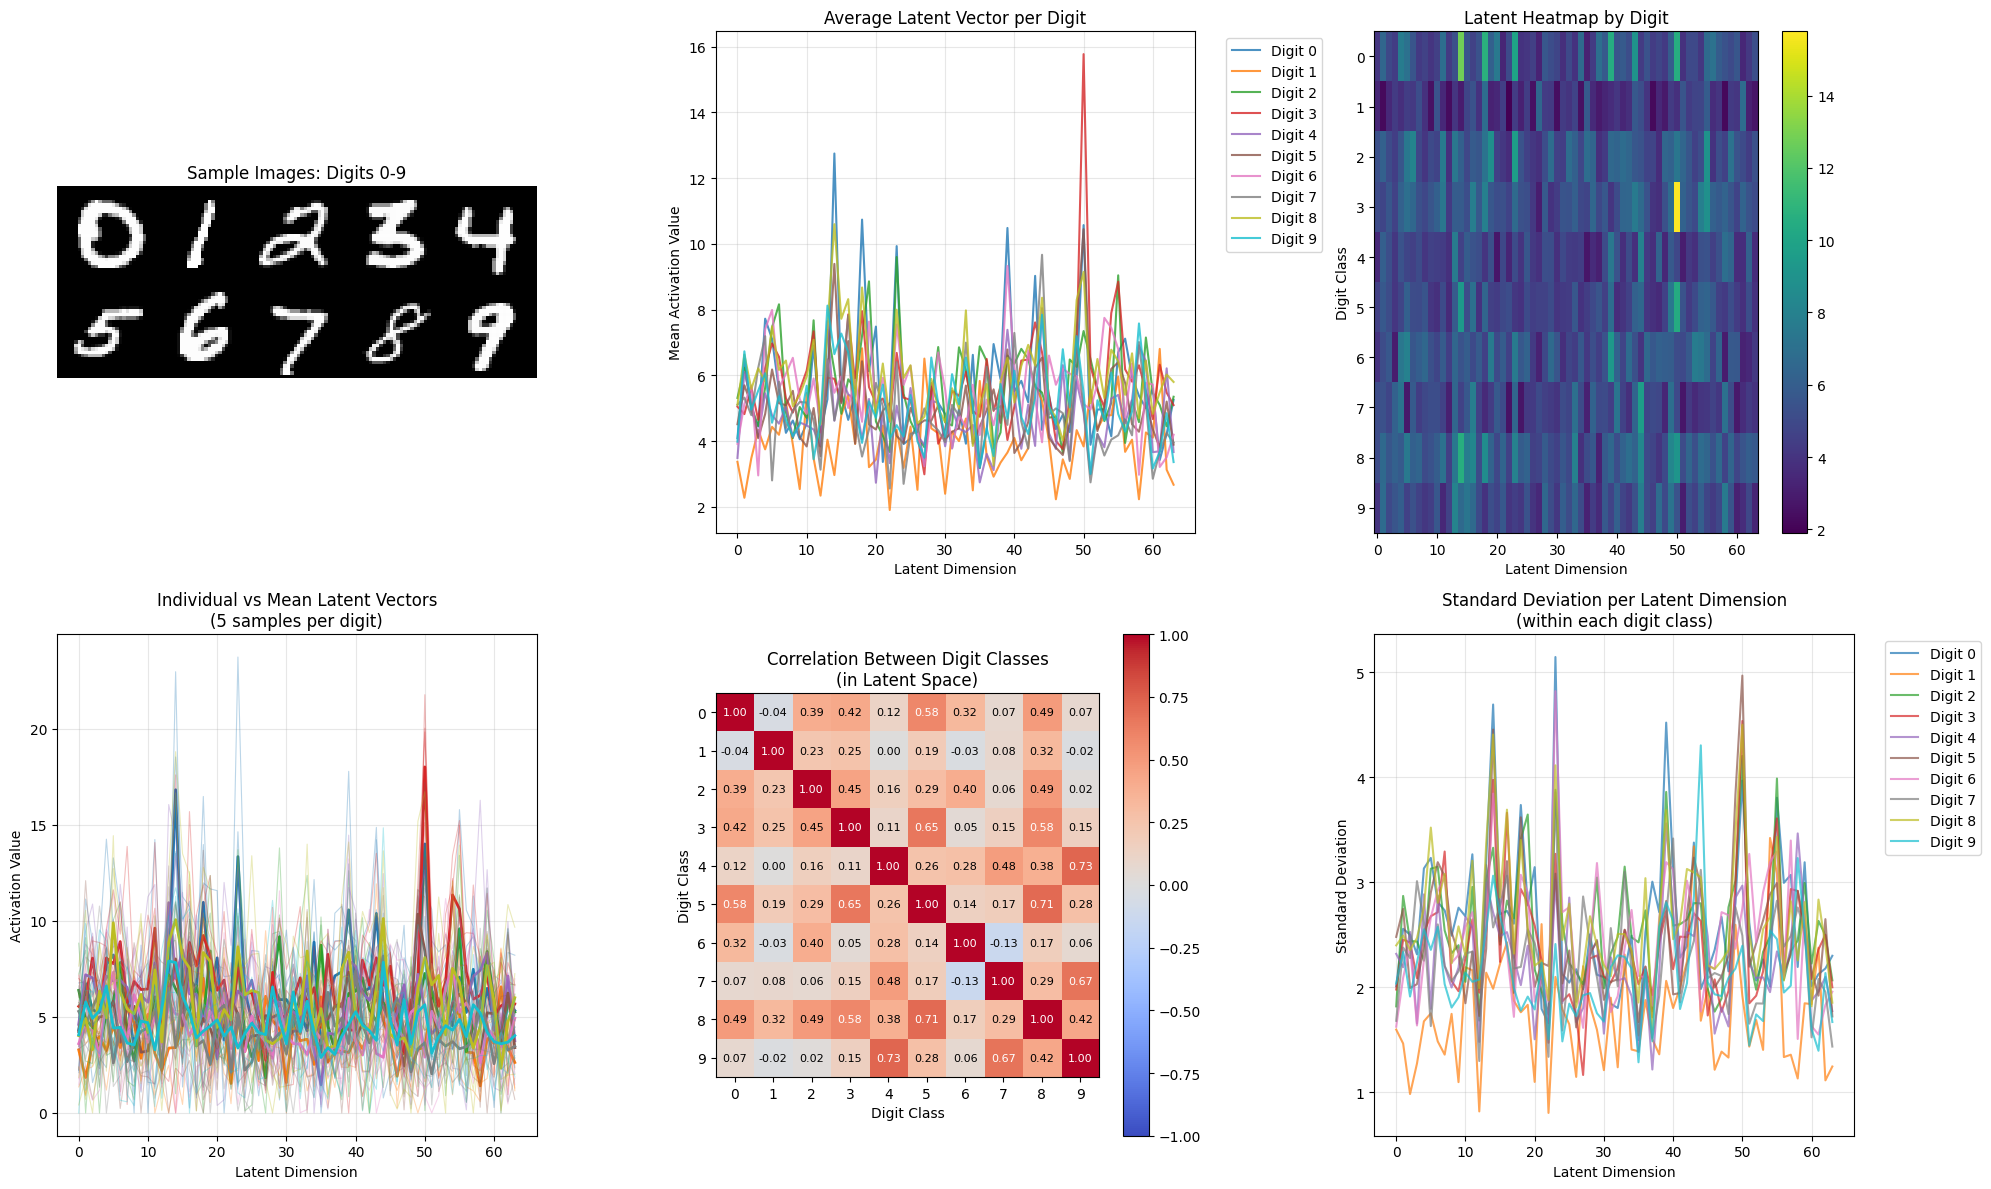

=== Latent Space Analysis by Digit ===
Digit 0: 108 samples, mean activation: 5.606, std: 3.342
Digit 1: 122 samples, mean activation: 4.001, std: 2.147
Digit 2: 113 samples, mean activation: 5.653, std: 2.965
Digit 3: 87 samples, mean activation: 5.806, std: 2.986
Digit 4: 85 samples, mean activation: 4.738, std: 2.555
Digit 5: 89 samples, mean activation: 5.054, std: 2.835
Digit 6: 103 samples, mean activation: 5.501, std: 2.838
Digit 7: 105 samples, mean activation: 4.888, std: 2.683
Digit 8: 99 samples, mean activation: 6.036, std: 3.035
Digit 9: 89 samples, mean activation: 5.109, std: 2.486

Overall average std within classes: 2.358
Most similar digit pairs (highest correlation):
  Digits 4 and 9: 0.726


In [ ]:
# Modified visualization to group latent vectors by digit class
def visualize_latent_space_by_digit():
    # Get encoded representations and labels for test images
    sample_images = x_test[:1000]  # Use more samples for better representation
    encoded_representations = autoencoder.encoder(sample_images).numpy()
    
    # We need the actual labels - let's get them from the original dataset
    # Reload MNIST with labels
    ds = tfds.load('mnist', split='test', as_supervised=True)
    labels = []
    for _, label in ds.take(1000):
        labels.append(label.numpy())
    labels = np.array(labels)
    
    plt.figure(figsize=(20, 12))
    
    # Plot 1: Show sample images for each digit
    plt.subplot(2, 3, 1)
    digit_samples = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) > 0:
            digit_samples.append(sample_images[digit_indices[0]])
    
    # Create a grid of sample digits 0-9
    sample_grid = np.zeros((28*2, 28*5))
    for i, img in enumerate(digit_samples):
        row = i // 5
        col = i % 5
        sample_grid[row*28:(row+1)*28, col*28:(col+1)*28] = img.squeeze()
    
    plt.imshow(sample_grid, cmap='gray')
    plt.title('Sample Images: Digits 0-9')
    plt.axis('off')
    
    # Plot 2: Compare average latent vectors for each digit
    plt.subplot(2, 3, 2)
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) > 0:
            digit_latents = encoded_representations[digit_indices]
            mean_latent = np.mean(digit_latents, axis=0)
            plt.plot(mean_latent, label=f'Digit {digit}', color=colors[digit], alpha=0.8)
    
    plt.title('Average Latent Vector per Digit')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Mean Activation Value')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Heatmap of mean latent vectors
    plt.subplot(2, 3, 3)
    mean_latents = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) > 0:
            digit_latents = encoded_representations[digit_indices]
            mean_latents.append(np.mean(digit_latents, axis=0))
        else:
            mean_latents.append(np.zeros(64))
    
    mean_latents = np.array(mean_latents)
    plt.imshow(mean_latents, cmap='viridis', aspect='auto')
    plt.title('Latent Heatmap by Digit')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Digit Class')
    plt.yticks(range(10))
    plt.colorbar()
    
    # Plot 4: Show variability within each digit class
    plt.subplot(2, 3, 4)
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) >= 5:  # Need at least 5 samples
            digit_latents = encoded_representations[digit_indices[:5]]  # Take first 5
            for i, latent in enumerate(digit_latents):
                plt.plot(latent, color=colors[digit], alpha=0.3, linewidth=0.8)
            # Plot mean on top
            mean_latent = np.mean(digit_latents, axis=0)
            plt.plot(mean_latent, color=colors[digit], linewidth=2, label=f'Digit {digit}')
    
    plt.title('Individual vs Mean Latent Vectors\n(5 samples per digit)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Activation Value')
    plt.grid(True, alpha=0.3)
    
    # Plot 5: Correlation matrix between digit classes
    plt.subplot(2, 3, 5)
    correlation_matrix = np.corrcoef(mean_latents)
    im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Between Digit Classes\n(in Latent Space)')
    plt.xlabel('Digit Class')
    plt.ylabel('Digit Class')
    plt.xticks(range(10))
    plt.yticks(range(10))
    
    # Add correlation values as text
    for i in range(10):
        for j in range(10):
            plt.text(j, i, f'{correlation_matrix[i,j]:.2f}', 
                    ha='center', va='center', 
                    color='white' if abs(correlation_matrix[i,j]) > 0.5 else 'black',
                    fontsize=8)
    plt.colorbar(im)
    
    # Plot 6: Standard deviation within each class
    plt.subplot(2, 3, 6)
    std_per_digit = []
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) > 1:
            digit_latents = encoded_representations[digit_indices]
            std_latent = np.std(digit_latents, axis=0)
            std_per_digit.append(np.mean(std_latent))  # Average std across dimensions
            plt.plot(std_latent, color=colors[digit], alpha=0.7, label=f'Digit {digit}')
        else:
            std_per_digit.append(0)
    
    plt.title('Standard Deviation per Latent Dimension\n(within each digit class)')
    plt.xlabel('Latent Dimension')
    plt.ylabel('Standard Deviation')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("=== Latent Space Analysis by Digit ===")
    for digit in range(10):
        digit_indices = np.where(labels == digit)[0]
        if len(digit_indices) > 0:
            digit_latents = encoded_representations[digit_indices]
            mean_activation = np.mean(digit_latents)
            std_activation = np.std(digit_latents)
            print(f"Digit {digit}: {len(digit_indices)} samples, "
                  f"mean activation: {mean_activation:.3f}, "
                  f"std: {std_activation:.3f}")
    
    print(f"\nOverall average std within classes: {np.mean(std_per_digit):.3f}")
    print("Most similar digit pairs (highest correlation):")
    
    # Find most correlated pairs
    correlation_matrix = np.corrcoef(mean_latents)
    np.fill_diagonal(correlation_matrix, -2)  # Ignore self-correlation
    max_corr_idx = np.unravel_index(np.argmax(correlation_matrix), correlation_matrix.shape)
    print(f"  Digits {max_corr_idx[0]} and {max_corr_idx[1]}: {correlation_matrix[max_corr_idx]:.3f}")

visualize_latent_space_by_digit()

# TODO: heat maps like for cats/dogs project; add a last classification layer and freeze all up to last 1-2 layers

## Interpreting the Latent Space Correlation Matrix

The correlation matrix between digit classes in latent space reveals fascinating insights about how the autoencoder perceives visual similarities:

### High Correlation (Similar Latent Representations)
- **Digits 4 and 9** show high correlation, which makes intuitive sense given their structural similarities:
  - Both contain a **straight vertical line** as a dominant feature
  - Both have an **enclosed region** (loop or angular closure) in the upper portion
  - The autoencoder appears to capture this shared "vertical line + upper enclosure" pattern

### Low Correlation (Distinct Latent Representations)
- **Digits 0 and 1** show very low correlation, reflecting their fundamental structural differences:
  - **Digit 0**: Primarily a closed loop/oval shape with no straight lines
  - **Digit 1**: Primarily a straight vertical line with minimal curvature
  - These represent opposite ends of the "curvature vs. linearity" spectrum

### Key Insights
1. **Shape-based encoding**: The autoencoder learns to encode digits based on fundamental geometric properties rather than just pixel patterns
2. **Structural similarity detection**: High correlations often correspond to digits that share basic structural elements (lines, curves, enclosures)
3. **Perceptual organization**: The latent space organization mirrors human intuition about digit similarities - we also perceive 4 and 9 as more similar than 0 and 1

This demonstrates that even a simple autoencoder with basic dense layers can learn meaningful geometric representations that capture the essential visual structure